# MODELISATION

## Imports librairies et jeu de données

In [303]:
# Standards Librairies import
import os
from time import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA,KernelPCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from scipy.stats import pearsonr

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance


In [304]:
#Vérifier le répertoire de travail
import os
print(os.getcwd()) 
#modifie le répertoire de travail 
pwd = "/kaggle/input"
os.chdir(pwd)
 
#affiche le nouveau repertoire de travail 
print(os.getcwd())

/kaggle/input
/kaggle/input


In [305]:
##Chargement de la base
data = pd.read_csv('/kaggle/input/basefinale/basefinale.csv')

In [306]:
## dimension de notre dataset
data.shape

(122968, 20)

In [307]:
## données manquantes
data.isna().sum()

Unnamed: 0                       0
customer_id                      0
customer_unique_id               0
customer_city                    0
customer_state                   0
price                            0
freight_value                    0
payment_type                     0
payment_value                    0
review_score                     0
product_category_name_english    0
Nb_tot_pdts                      0
Tot_moy_achats                   0
Mont_max_achats                  0
nb_payment_dif_com               0
nmbre_echea_tot                  0
nb_commandes                     0
Note_Moy_Com                     0
Cat_la_plus_achetee              0
Nb_moy_pdts_par_com              0
dtype: int64

In [308]:
data.drop(['customer_unique_id', 'customer_id', 'Unnamed: 0'] ,axis=1, inplace=True)

## I. Quelques traitements

In [354]:
# regroupement des varibles selon leur types dans des listes
var_numeric= list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
var_quali= categorical_features = list(data.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)

In [355]:
var_numeric

['price',
 'freight_value',
 'payment_value',
 'review_score',
 'Nb_tot_pdts',
 'Tot_moy_achats',
 'Mont_max_achats',
 'nb_payment_dif_com',
 'nmbre_echea_tot',
 'nb_commandes',
 'Note_Moy_Com',
 'Nb_moy_pdts_par_com']

In [356]:
var_quali

['customer_city',
 'customer_state',
 'payment_type',
 'product_category_name_english',
 'Cat_la_plus_achetee']

### Division de notre jeu de données

In [357]:
# Divisons de notre jeu de données en donnée test et 
from sklearn.model_selection import train_test_split
X_train, X_test,  = train_test_split(
                     data,  test_size=0.2, random_state=123)
X_test1= X_test.copy()
X_test1.shape

(24594, 17)

## II. Clustering avec l'algorithme du K-Means

In [358]:
### drop des var quali 
X_test1.drop(['customer_city', 'customer_state', 'product_category_name_english', 'payment_type', 'Cat_la_plus_achetee'],axis=1, inplace=True)

In [359]:
X_test1

,price,freight_value,payment_value,review_score,Nb_tot_pdts,Tot_moy_achats,Mont_max_achats,nb_payment_dif_com,nmbre_echea_tot,nb_commandes,Note_Moy_Com,Nb_moy_pdts_par_com
6018,19.99,7.39,27.38,5.0,1,19.99,19.99,1.0,2.0,2,5.00,2.0
44411,195.90,18.94,859.36,5.0,4,783.60,195.90,4.0,4.0,3,1388.75,12.0
13002,229.99,21.10,251.09,5.0,1,229.99,229.99,1.0,6.0,1,5.00,1.0
57826,110.00,15.52,125.52,5.0,1,110.00,110.00,1.0,1.0,1,5.00,1.0
54029,59.90,17.67,77.57,3.0,1,59.90,59.90,1.0,1.0,1,3.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4449,23.89,9.34,33.23,3.0,1,23.89,23.89,1.0,1.0,1,3.00,1.0
109252,24.98,15.10,120.24,5.0,3,74.94,24.98,3.0,24.0,1,185.00,3.0
80196,29.49,19.40,48.89,5.0,1,29.49,29.49,1.0,1.0,1,5.00,1.0
115098,74.89,8.68,83.57,4.0,1,74.89,74.89,1.0,1.0,1,4.00,1.0


### II.1 Standardisation des données

 La standardisation des données consiste à les centrer autour de leur moyenne et à les réduire à une échelle commune. Cela permet de rendre les variables comparables et de s'assurer que l'ACP ne soit pas influencée par les différences d'échelle entre les variables. 
Il est important de standardiser les données avant de les utiliser dans l'ACP car cela permet de mettre toutes les variables sur la même échelle. Ainsi, une variable qui a des valeurs plus élevées ne dominera pas une variable avec des valeurs plus faibles lors de la détermination des clusters. Cela peut également améliorer la performance de nos algorithmes en réduisant le temps de calcul

on utilsiera la méthode StandardScaler de Sklearn pour la standardisation

In [360]:
scaler= StandardScaler()
X_Sta_test= scaler.fit_transform(X_test1) 
type(X_test1) #le type de nos données transformées

pandas.core.frame.DataFrame

In [361]:
#visualisation
X_Sta_test

array([[-0.54904266, -0.7912491 , -0.56662098, ...,  1.53493581,
        -0.03985312, -0.05252893],
       [ 0.42796331, -0.0658657 ,  2.67252051, ...,  3.34246328,
        -0.03985312,  1.17890428],
       [ 0.61729952,  0.06979041,  0.30434749, ..., -0.27259166,
        -0.03985312, -0.17567226],
       ...,
       [-0.49627956, -0.03697597, -0.48287625, ..., -0.27259166,
        -0.03985312, -0.17567226],
       [-0.24412749, -0.71023226, -0.34785687, ..., -0.27259166,
        -0.03985312, -0.17567226],
       [-0.1657604 ,  0.29085964,  0.21149246, ..., -0.27259166,
        -0.03985312, -0.05252893]])

### II. 2 K-means avec les données brutes

Clustering avec l'algorithme du K-Means
Explication de l'algorithme
K-Means C’est l’un des algorithmes de clustering les plus répandus. Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes *(ou clusters).

Après avoir initialisé des centroïdes en prenant des données au hasard dans le jeu de données, K-means alterne plusieurs fois ces deux étapes pour optimiser les centroïdes et leurs groupes :

* Regrouper chaque objet autour du centroïde le plus proche.
* Replacer chaque centroïde selon la moyenne des descripteurs de son groupe.
L’algorithme a convergé après un certain nombre d'itérations et trouve un découpage stable du jeu de données. Cependant, le nombre de Clusters est à définir par l'utilisateur

   #### 1. Methode du coude 

Pour déterminer le nombre de clusters optimal à utiliser nous allons utilisé la méthode de Coude en ajustant le modèle K-Means avec une plage de valeurs pour K

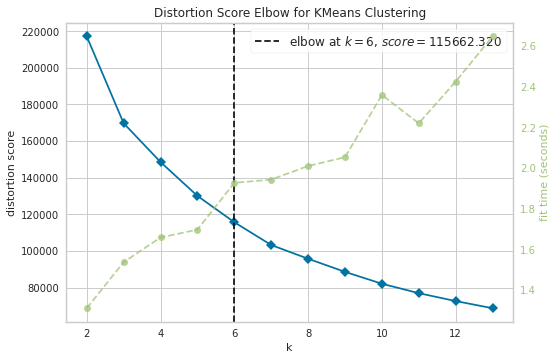

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [362]:
## Méthode de coude
kmeans=KMeans()

visualizer= KElbowVisualizer (kmeans, k= (2,14))
#ON APPLIQUE NOTRE VISUALISER SUR NOTRE JEU DE DONNEES
visualizer.fit(X_Sta_test)

##affichage du graphe coude

visualizer.show()

In [412]:
### clustering avec 6 clusters
Kmeans1= KMeans(n_clusters=6)
#ON APPLIQUE LE MODELE AU DONNEES AVEC fit ()
Kmeans1.fit(X_Sta_test)
#garder les cluster dans une variable
clusters_kmeans1=Kmeans1.predict(X_Sta_test)

#### 2. Caractérisation des clusters k-means

In [364]:
##ajouter des clusters dans notre bases 
X_test1['clusters_kmeans']= clusters_kmeans1

##calcul des différents moyenne par clusters
Xt_kmean1=X_test1.groupby(['clusters_kmeans']).mean()
Xt_kmean1

,price,freight_value,payment_value,review_score,Nb_tot_pdts,Tot_moy_achats,Mont_max_achats,nb_payment_dif_com,nmbre_echea_tot,nb_commandes,Note_Moy_Com,Nb_moy_pdts_par_com
clusters_kmeans,,,,,,,,,,,,
0,82.265773,17.182525,114.492029,4.758143,1.373992,105.161065,82.969414,1.373992,3.511683,1.157354,1.604422e+04,1.680631
1,105.249807,20.375910,463.915781,3.487923,10.070853,998.126409,119.524557,10.070853,37.239936,1.362319,1.883399e+34,14.919485
2,1503.221218,65.850254,1745.669137,4.106599,1.619289,2141.275178,1528.199645,1.619289,7.923858,1.055838,3.760105e+11,1.746193
3,40.224615,16.252308,7.151795,5.000000,63.000000,2305.380000,83.800000,63.000000,63.000000,2.000000,8.818342e+60,189.000000
4,83.115847,18.237924,141.662400,1.868588,1.713718,129.428915,86.521612,1.713718,4.929225,1.119483,4.639143e+03,2.210139
5,387.633658,43.612812,502.590871,4.255319,1.479230,504.057112,392.516028,1.479230,6.713273,1.101317,4.214256e+04,1.752786


In [365]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [366]:
plot_radars(data=Xt_kmean1,
            group="clusters_kmeans")

Nous allons à présent réaliser une réduction dimensionnelle pour vérifier si le clustering est réalisable sur un nombre réduit de variables sans perturber les groupes

### II.3 K-means avec reduction dimensionnelle

#### 1. Reduction de dimention

##### 1.1 ACP linéaire

L'analyse en composantes principales (ACP) linéaire est basée sur la décomposition en valeurs singulières (SVD) et suppose que les données sont linéairement liées. Elle permet de réduire les dimensions des données en mettant en évidence les directions principales de variation des données, qui sont des combinaisons linéaires des variables d'origine

 ###### a. Nombre de composantes optimal pour l'ACP

On utilisera la méthode de l'elbow pour déterminer le nombre optimal de composantes. La méthode de l'elbow consiste à tracer le pourcentage de variance expliquée par chaque composante, puis à choisir le nombre de composantes qui correspond à l'endroit où la courbe forme un coude.

on instancie un objet PCA et on ajuste les données à l'ACP. Ensuite, on trace le pourcentage de variance expliquée par chaque composante, on utilise une boucle while pour determiner le nombre optimal de composante en comparant la variance expliquée entre les composante, et on affiche le résultat.

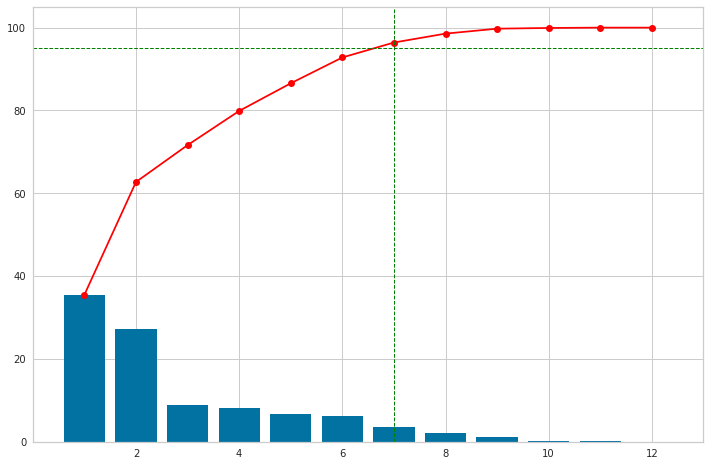

In [367]:
# Initialiser l'ACP
pca = PCA()

# Ajuster les données à l'ACP
pca=pca.fit(X_Sta_test)

# Variance expliquée
varexpl = pca.explained_variance_ratio_*100

# graphe des variance cumulées
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

Il faut donc conserver 7 axes principaux pour pouvoir expliquer la variance à 95% de nos données

###### b. L'analyse

In [368]:
pca = PCA(n_components = 7)
X_pca = pca.fit_transform(X_Sta_test)


###### c. Visualisation des données

In [371]:
comp1 = X_pca[:,0]
comp2 = X_pca[:,1]

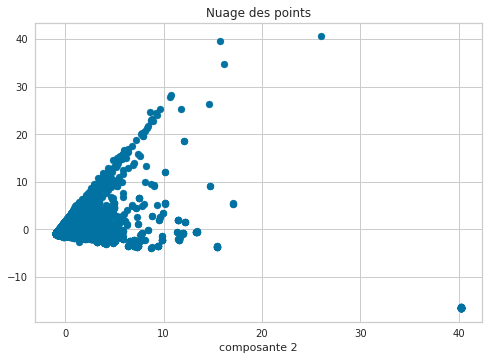

In [372]:
plt.scatter(X_pca[:, 0],X_pca[:, 1])
plt.xlabel ("composante 1")
plt.xlabel ("composante 2")
plt.title("Nuage des points")
plt.show()

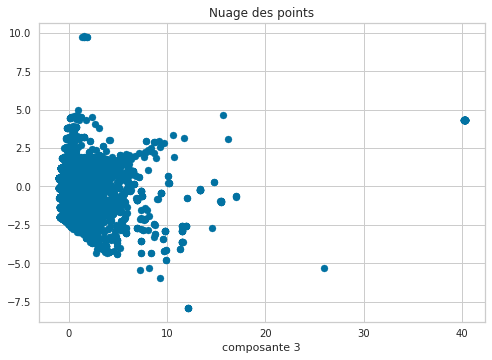

In [373]:
## Nuages des individus
plt.scatter(X_pca[:, 0],X_pca[:, 2])
plt.xlabel ("composante 1")
plt.xlabel ("composante 3")
plt.title("Nuage des points")
plt.show()

##### 1.2 ACP non linéaire

L'ACP non lineaire permet de faire une réduction de dimensionnalité non linéaire sur notre jeu de données. Nous utiliseront nos données de test standardisées (X_Sta_test)
la fonction KernelPCA de Sklearn pour son execution

In [374]:
kpca=KernelPCA(n_components=2 , kernel = 'rbf')
X_kpca=kpca.fit_transform(X_Sta_test)
X_kpca

array([[-0.10304426,  0.05891294],
       [ 0.51162277,  0.35757107],
       [-0.07192697,  0.32634792],
       ...,
       [-0.33356176, -0.02945223],
       [-0.20160099, -0.21453891],
       [-0.2159813 ,  0.14365937]])

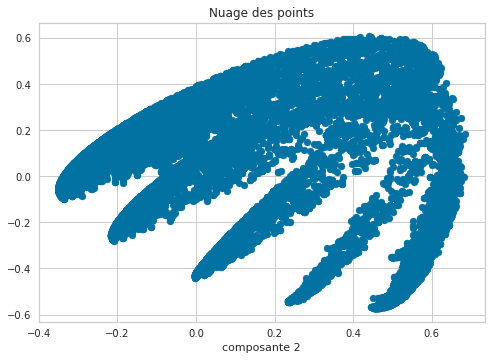

In [375]:
plt.scatter(X_kpca[:, 0],X_kpca[:, 1])
plt.xlabel ("composante 1")
plt.xlabel ("composante 2")
plt.title("Nuage des points")
plt.show()

#### 2. Methode du coude 

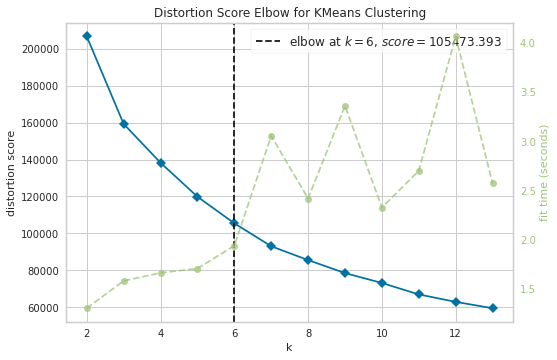

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [376]:
## Méthode de coude
kmeans=KMeans()

visualizer= KElbowVisualizer (kmeans, k= (2,14))
#ON APPLIQUE NOTRE VISUALISER SUR NOTRE JEU DE DONNEES
visualizer.fit(X_kpca)

##affichage du graphe coude

visualizer.show()

#### 3. l'Alghorithme de k-means

In [342]:
### clustering avec 6 clusters
kmeans2= KMeans(n_clusters=6)
#ON APPLIQUE LE MODELE AU DONNEES AVEC fit ()
kmeans2.fit(X_kpca)
#garder les cluster dans une variable
clusters_kmeans2=kmeans2.predict(X_kpca)

In [343]:
clusters_kmeans2

array([2, 2, 5, ..., 0, 0, 0], dtype=int32)

##### Caractérisation des clusters k-means

In [377]:
##ajouter des clusters dans notre bases
X_test2['clusters_kmeans']= clusters_kmeans2


##calcul des différents moyenne par clusters
Xt_kmean2=X_test2.groupby(['clusters_kmeans']).mean()
Xt_kmean2

,price,freight_value,payment_value,review_score,Nb_tot_pdts,Tot_moy_achats,Mont_max_achats,nb_payment_dif_com,nmbre_echea_tot,nb_commandes,Note_Moy_Com,Nb_moy_pdts_par_com
clusters_kmeans,,,,,,,,,,,,
0.0,118.905055,20.003410,185.436319,4.138990,2.152727,208.944048,121.543608,2.152727,6.004848,1.175758,6.057043e+58,3.569293
1.0,115.951222,20.236736,179.743631,4.040342,2.458435,229.865501,119.677665,2.458435,6.088020,1.146699,9.702332e+58,4.316626
2.0,117.876296,18.994127,168.613598,4.039683,1.925926,183.649656,120.053122,1.925926,5.412698,1.145503,4.665789e+58,2.965608
3.0,113.114300,18.807005,161.860386,4.106280,2.555556,201.583913,115.506425,2.555556,5.130435,1.159420,1.278021e+59,4.719807
4.0,133.438971,19.663860,186.007647,3.944853,1.926471,223.048162,136.848824,1.926471,6.966912,1.169118,3.242038e+58,2.955882
5.0,112.134973,20.664324,157.623081,4.067568,2.716216,210.796757,113.478838,2.716216,5.389189,1.140541,1.668335e+59,5.494595


In [378]:
plot_radars(data=Xt_kmean2,
            group="clusters_kmeans")

##### commentaire sur les clusters

#### 4 Evaluation 

In [379]:
Coef1=silhouette_score(X_Sta_test, kmeans2.fit_predict(X_Sta_test))
Coef2=silhouette_score(X_kpca, kmeans2.fit_predict(X_kpca))

In [380]:
Coef1

0.35668499823985944

In [381]:
Coef2

0.5125201900852422

<span style="color:red"> REMARQUE </span>
La réduction de dimenssion offre les mêmes clusters. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de l'ACP pour segmenter notre fichier client, ce d'autant plus que le score silhouette est  meilleurs comparés au k-means utilisant les données brutes

Nous allons donc conserver le modèle de k-means avec une réduction dimentionnelle lors de l'évaluation des modèles

## III. Classification Ascendante Hierarchique

Le clustering hiérarchique a l’avantage de ne pas requérir de définir à l’avance le nombre de clusters, ce qui permet d’explorer toutes les possibilités le long du dendrogramme. Cependant, il faut généralement prendre cette décision à un moment. Il est possible pour cela d’utiliser un dendrogramme, pour y déceler un « niveau » auquel les clusters sont clairement distants les uns des autres. Ainsi pour determiner le nombres de clusters. Toutefois Une solution alternative est d’évaluer les différents modèles pour différentes valeurs de k et vérifier la partition optimale à l’aide d’une mesure de performance telle que le coefficient de silhouette. 
    

### III.1 Determination du nombre de clusters optimal

In [382]:
X_test3= X_test.copy()

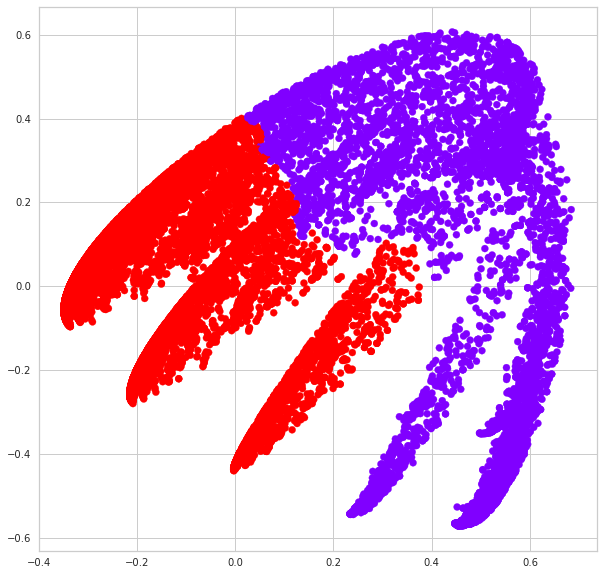

In [383]:
#model 1
CAH_1 = AgglomerativeClustering(n_clusters = 2)
plt.figure(figsize =(10, 10))
plt.scatter(X_kpca[:,0], X_kpca[:,1],
            c = CAH_1.fit_predict(X_kpca), cmap ='rainbow')
plt.show()

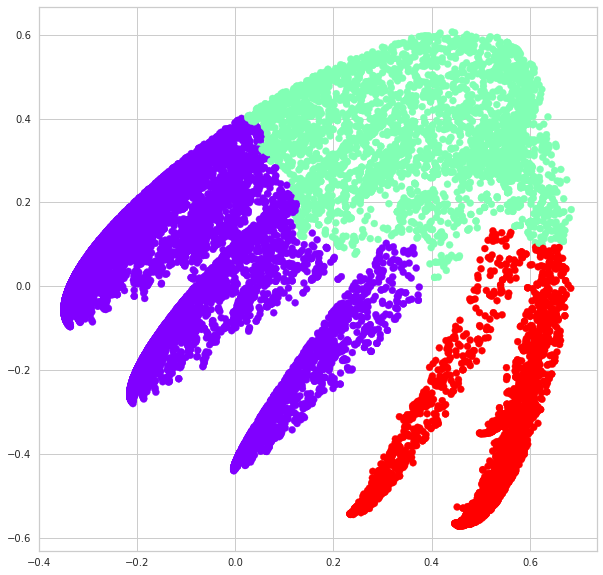

In [384]:
#model 2
CAH_2 = AgglomerativeClustering(n_clusters = 3)
plt.figure(figsize =(10, 10))
plt.scatter(X_kpca[:,0], X_kpca[:,1],
            c = CAH_2.fit_predict(X_kpca), cmap ='rainbow')
plt.show()

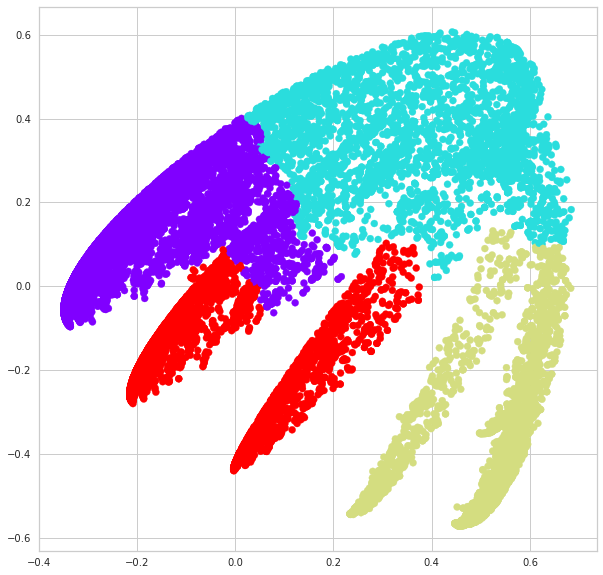

In [385]:
#model 3
CAH_3 = AgglomerativeClustering(n_clusters = 4)
plt.figure(figsize =(10, 10))
plt.scatter(X_kpca[:,0], X_kpca[:,1],
            c = CAH_3.fit_predict(X_kpca), cmap ='rainbow')
plt.show()  

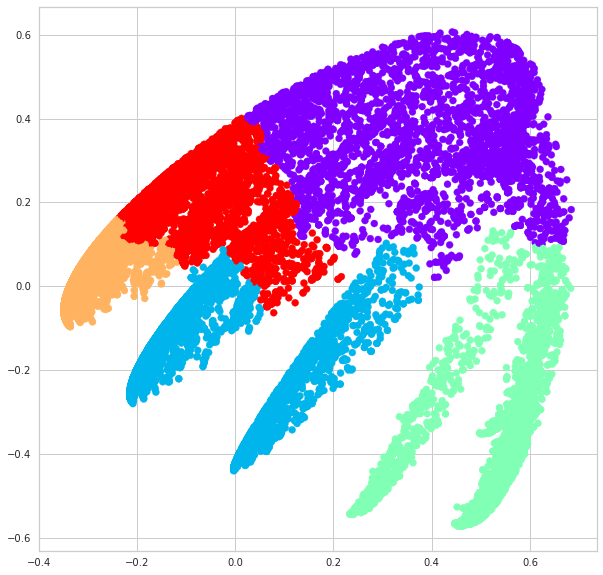

In [386]:
#model 5
CAH_4 = AgglomerativeClustering(n_clusters = 5)
plt.figure(figsize =(10, 10))
plt.scatter(X_kpca[:,0], X_kpca[:,1],
            c = CAH_4.fit_predict(X_kpca), cmap ='rainbow')
plt.show() 

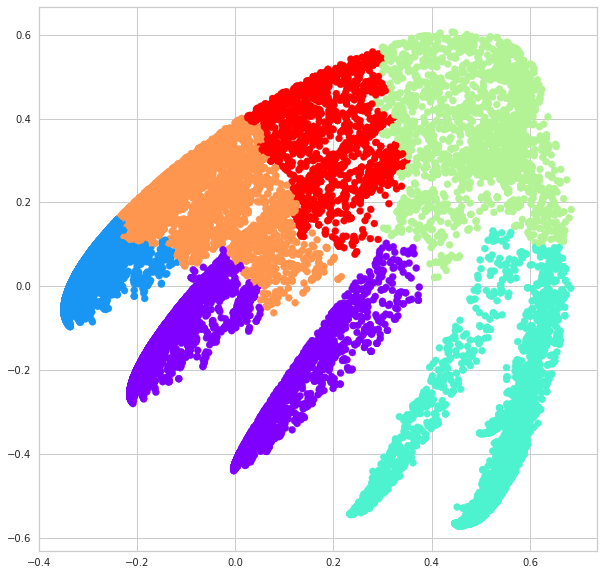

In [387]:
#model 6
CAH_5 = AgglomerativeClustering(n_clusters = 6)
plt.figure(figsize =(10, 10))
plt.scatter(X_kpca[:,0], X_kpca[:,1],
            c = CAH_5.fit_predict(X_kpca), cmap ='rainbow')
plt.show()    

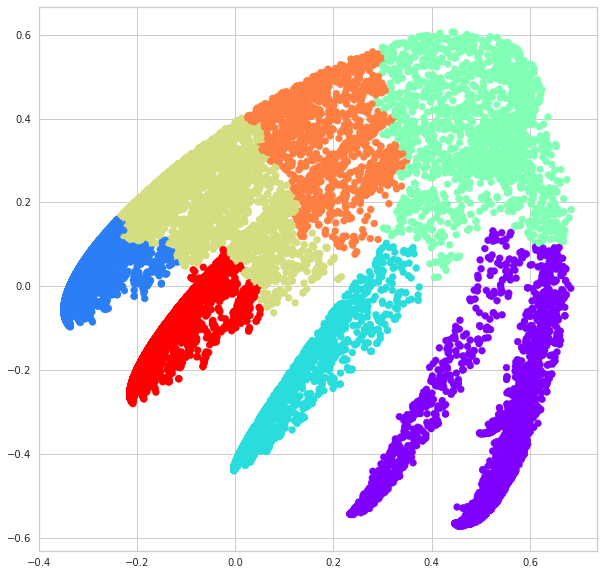

In [389]:
#model 7
CAH_6 = AgglomerativeClustering(n_clusters = 7)
plt.figure(figsize =(10, 10))
plt.scatter(X_kpca[:,0], X_kpca[:,1],
            c = CAH_6.fit_predict(X_kpca), cmap ='rainbow')
plt.show()  

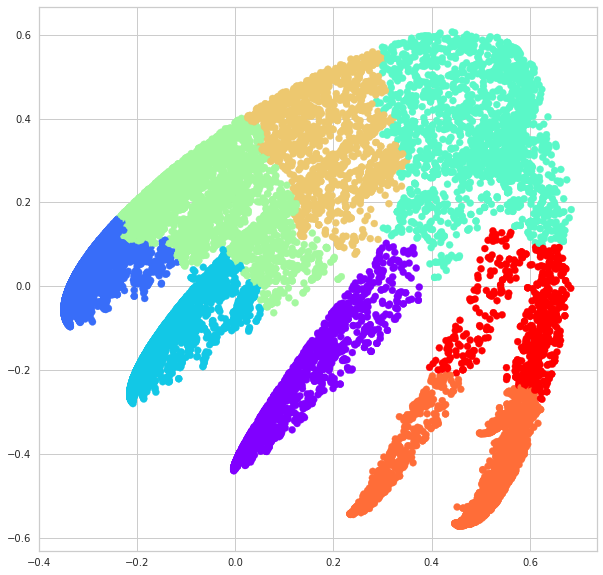

In [390]:
#model 8
CAH_7 = AgglomerativeClustering(n_clusters = 8)
plt.figure(figsize =(10, 10))
plt.scatter(X_kpca[:,0], X_kpca[:,1],
            c = CAH_7.fit_predict(X_kpca), cmap ='rainbow')
plt.show()   
  

#### 1. Coefficient de silhouette

Afin de retenir un nombre de clusters optimal, nous allons visualiser les coefficients des differents modèles ci-dessus et retenir celui qui minimise ce coefficient

In [391]:
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(X_kpca, CAH_1.fit_predict(X_kpca)))
silhouette_scores.append(
        silhouette_score(X_kpca, CAH_2.fit_predict(X_kpca)))
silhouette_scores.append(
        silhouette_score(X_kpca, CAH_3.fit_predict(X_kpca)))
silhouette_scores.append(
        silhouette_score(X_kpca, CAH_4.fit_predict(X_kpca)))
silhouette_scores.append(
        silhouette_score(X_kpca, CAH_5.fit_predict(X_kpca)))
silhouette_scores.append(
        silhouette_score(X_kpca, CAH_6.fit_predict(X_kpca)))
silhouette_scores.append(
        silhouette_score(X_kpca, CAH_7.fit_predict(X_kpca)))

#### 2. Visualisation des coefficients

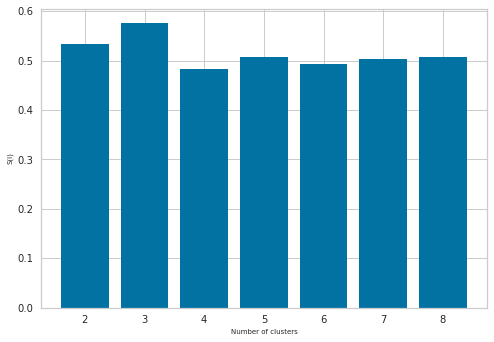

In [392]:
# Plotting a bar graph to compare the results
import matplotlib.pyplot as plt
k = [2, 3, 4, 5, 6, 7, 8]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 7)
plt.ylabel('S(i)', fontsize = 7)
plt.show()

Ainsi, à l'aide des scores de silhouette, il est conclu que le nombre optimal de clusters pour les données et la technique de clustering données est de 3

### III.2 CAH sur les données testes

Nous allons d'abord presenter un dendrogramme tout en initialisant d'abord le seuil (thresholds) à 0 et ensuite par l'analyse de ce graphique nous allons estimer le seui qui nous donnes une partition de 3 classes  

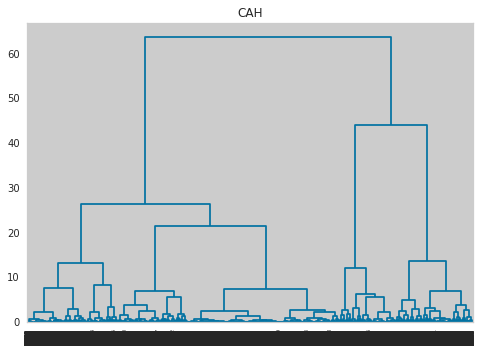

In [394]:
from scipy.cluster.hierarchy import linkage,dendrogram
Z = linkage(X_kpca,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,orientation='top',color_threshold=0)
plt.show()

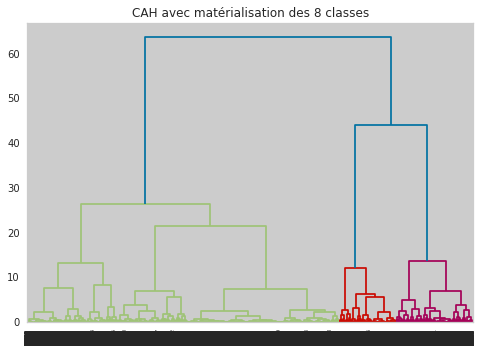

[1 3 1 ... 1 1 1]


In [397]:
from scipy.cluster.hierarchy import ward, fcluster
#matérialisation des 3 classes (hauteur t = 30)
plt.title('CAH avec matérialisation des 3 classes')
dendrogram(Z,orientation='top',color_threshold=30)
plt.show()
#découpage à la hauteur t = 30 ==> identifiants de 3 groupes obtenus
groupes_cah = fcluster(Z,t=30,criterion='distance')
print(groupes_cah)
#index triés des groupes
idg = np.argsort(groupes_cah)

On remarque que les résultats obtenus ici ne sont pas vraissemblables vu la taille de nos données. Le CAH a un temps d'entrainement et de prédiction plus long, nous allons donc conserver la segmentation avec le modèle K-Means.

## Entrainement du modèle final

### I. Standardisation des données

In [404]:
X_train1= X_train.copy()
X_train1.drop(['customer_city', 'customer_state', 'product_category_name_english', 'payment_type','payment_type', 'Cat_la_plus_achetee'],axis=1, inplace=True)

In [405]:
scaler= StandardScaler()
X_Sta_test2= scaler.fit_transform(X_train1) 

### II.Reduction dimentionnelle (ACP linéaire)

### II.1 Nombre de composantes optimal

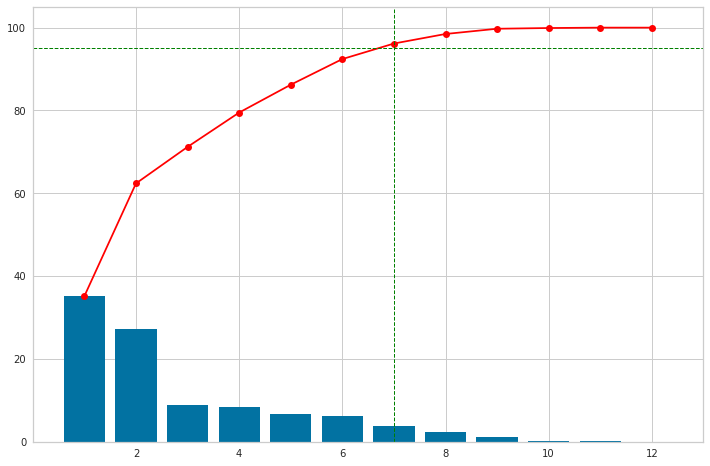

In [406]:
# Initialiser l'ACP
pca = PCA()

# Ajuster les données à l'ACP
pca=pca.fit(X_Sta_test2)

# Variance expliquée
varexpl = pca.explained_variance_ratio_*100

# graphe des variance cumulées
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

In [407]:
pca2 = PCA(n_components = 7)
X_pca2 = pca.fit_transform(X_Sta_test2)

### III. K-MEANS

### III.1 Methode de coude

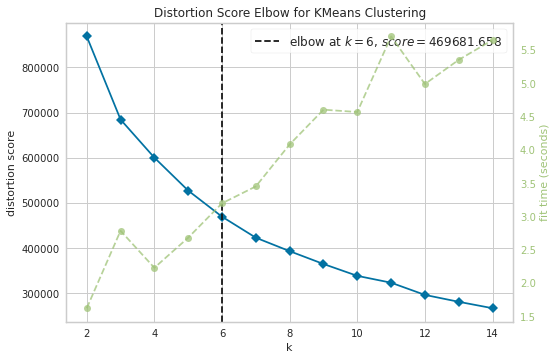

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [408]:
## Méthode de coude
kmeans=KMeans()

visualizer= KElbowVisualizer (kmeans, k= (2,15))
#ON APPLIQUE NOTRE VISUALISER SUR NOTRE JEU DE DONNEES
visualizer.fit(X_pca2)

##affichage du graphe coude

visualizer.show()

### III.2 k-means 

In [409]:
### clustering avec 5 clusters
kmeansf= KMeans(n_clusters=5)
#ON APPLIQUE LE MODELE AU DONNEES AVEC fit ()
kmeansf.fit(X_pca2)
#garder les cluster dans une variable
clusters_kmeansf=kmeansf.predict(X_pca2)

In [410]:
##ajouter des clusters dans notre bases

X_train['clusters_kmeans']= clusters_kmeansf

##calcul des différents moyenne par clusters
Xt_kmeanf=X_train.groupby(['clusters_kmeans']).mean()
Xt_kmeanf

,price,freight_value,payment_value,review_score,Nb_tot_pdts,Tot_moy_achats,Mont_max_achats,nb_payment_dif_com,nmbre_echea_tot,nb_commandes,Note_Moy_Com,Nb_moy_pdts_par_com
clusters_kmeans,,,,,,,,,,,,
0,94.126620,19.527539,154.569976,1.879608,1.660259,141.532134,97.579205,1.660259,4.718412,1.111261,2.330411e+03,2.091604
1,89.909093,20.322132,398.205620,3.577082,8.241878,735.959973,103.555564,8.241878,32.757531,1.821618,1.295323e+34,13.091849
2,35.649200,17.421200,7.819733,5.000000,63.000000,2305.380000,83.800000,63.000000,63.000000,2.000000,8.818342e+60,189.000000
3,883.930064,54.422701,1065.449210,4.077528,1.600929,1268.235795,897.340547,1.600929,7.659879,1.064309,1.861979e+11,1.787424
4,96.566994,18.670802,131.623815,4.758170,1.372501,123.163889,97.566962,1.372501,3.637242,1.138491,1.352091e+04,1.635838


### 3. Analyse des clusters par radar

In [413]:
plot_radars(data=Xt_kmeanf,
            group="clusters_kmeans")

## Conclusion

* Groupe 1 :nombre de paiement faible avec des  échéance total relativement faible, commandant principalement pour des montants faibles. Ils paient avec 1 type de moyen de paiement et avec un nombre faible d'échéances. Les avis de ces clients ne sont pas très bons.
* Groupe 2 :  Ils règlent avec plusieurs moyens de paiement pour des montants élevés. Les avis de ces clients sont très bons.Ils commandent peu avec beaucoups de produits de nature différente
* Groupe 3 : Regroupe les clients qui font beaucoups de commandes   et un nombre faible d'échéances (proche de 1) et   . Les avis de ces clients sont très faibles.
* Groupe 4 : Ce sont des clients qui font beaucoups dépenses à frais élevé sur les produits de prix élevés avec un nombre d'échéance très faibles. 
* Groupe 5 : Ce sont des clients  ont passé très peu de commandes et sont satisfaits . ils achètent des produits pas chers pour un montant moyen de dépense et des frais transaction relativement élevé.